In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from enum import Enum
from cartopy.feature.nightshade import Nightshade
from datetime import datetime


class Projection(Enum):
    Geographic = 1
    Polar = 2
    Azimuthal = 3
    

def plot_map(muf_data=None, aurora=None, grayline=False, spot_data=None, mhz=None, projection=Projection.Azimuthal, home_square=None, time=datetime.utcnow()):
    # projection
    geodetic_proj = ccrs.Geodetic()
    geographic_proj = ccrs.PlateCarree()
    geographic_proj._threshold = 0.1
    home = square_to_lon_lat(home_square) if home_square != None else [0, 90]

    if projection == Projection.Geographic:
        current_proj = geographic_proj 
    elif projection == Projection.Polar:
        current_proj = ccrs.AzimuthalEquidistant(home[0], 90)
    else:
        current_proj = ccrs.AzimuthalEquidistant(home[0], home[1])
        
    # base map
    fig = plt.figure(figsize=(22, 25))
    ax = plt.axes(projection=current_proj)        
    ax.set_global()   
    ax.coastlines(resolution='110m', alpha=0.9)
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linestyle='--', alpha=0.8)
    if grayline: ax.add_feature(Nightshade(time), alpha=0.4, color='silver', edgecolor='black')

    # title
    title = time.strftime('%Y-%m-%d %H:%M UTC')
    if mhz is not None: title = f'{title}  {mhz} MHz'
    if home_square is not None: title = f'{title}  {home_square}'
    plt.title(title, fontsize=15)

    # MUF
    if not muf_data is None:
        lons, lats = np.meshgrid(np.linspace(-180, 180, len(muf_data[0])), np.linspace(-90,90, len(muf_data)))
        contours = plt.contourf(lons, lats, muf_data, levels=[4,5.3,7,10.1,14,18,21,24.8,28,35], transform=geographic_proj, cmap='jet', alpha=0.5)
        plt.colorbar(orientation='horizontal', shrink=0.3, pad=0.02).ax.set_xlabel('MUF(3000), MHz')
        
    # aurora
    if aurora is not None:
        ax.imshow(aurora, vmin=0, vmax=100, transform=geographic_proj, extent=(0, 360, 90, -90), cmap='Greys')#, origin='lower', alpha=1, vmin=1,vmax=14)
        
    # spots
    if not spot_data is None:
        ax.scatter([s[0] for s in spot_data['stations']], [s[1] for s in spot_data['stations']], s=60, color='silver', edgecolors='gray', transform=geographic_proj, zorder=3)        
        for p in spot_data['paths']: plt.plot([p[0][0], p[1][0]], [p[0][1], p[1][1]], color='blue', transform=geodetic_proj, zorder=4)
        ax.scatter([s[0] for s in spot_data['path_ends']], [s[1] for s in spot_data['path_ends']], s=60, color='aqua', edgecolors='blue', transform=geographic_proj, zorder=5)

    # grid
    if home_square is None: 
        # no home location, plot lat/lon
        xlocs=np.linspace(-180,180,19)
        ylocs=np.linspace(-90,90,19)
        grid = ax.gridlines(color='magenta', alpha=0.7, xlocs=xlocs, ylocs=ylocs)
    else:
        if projection == Projection.Geographic:
            ax2 = fig.add_axes(ax.get_position(), projection=ccrs.RotatedPole(central_rotated_longitude=home[0], pole_latitude=home[1]))                    
        elif projection == Projection.Polar:
            ax2 = fig.add_axes(ax.get_position(), projection=ccrs.AzimuthalEquidistant(0, -home[1]))        
        else:
            ax2 = fig.add_axes(ax.get_position(), projection=ccrs.AzimuthalEquidistant(0, 90))        
            
        ax2.set_global()
        ax2.patch.set_facecolor('none')
        xlocs=np.linspace(-180,180,13)
        ylocs=np.linspace(90,-77,7)
        grid = ax2.gridlines(color='teal', alpha=0.7, xlocs=xlocs, ylocs=ylocs)
        ax.plot(home[0], home[1], marker='*', color='yellow', mec='olive', ms=20, zorder=9, transform=geographic_proj)
        
    grid.n_steps = 1000
    
    plt.savefig('map.png')
    plt.show()

In [2]:
letters='ABCDEFGHIJKLMNOPQRSTUVWX'
digits = '0123456789'
letters12 = dict([(letters[i] + letters[j], np.array([i*20.-180, j*10.-90])) for i in range(18) for j in range(18)])
digits34  = dict([(digits[i] + digits[j], np.array([2.*i, 1.*j])) for i in range(10) for j in range(10)])
letters56 = dict([(letters[i] + letters[j], np.array([2./24*i, 1./24*j])) for i in range(24) for j in range(24)])

def square_to_lon_lat(square):
    'Converts grid square to longitude and latitude.'
    if square is None:
        return None
    if len(square) == 2:    
        return letters12[square[:2]] + [10, 5] 
    if len(square) == 4:    
        return letters12[square[:2]] + digits34[square[2:4]] + [1, 0.5] 
    if len(square) == 6:    
        return letters12[square[:2]] + digits34[square[2:4]] + letters56[square[4:6]] + [1./24, 0.5/24] 
    return [0,0]

### Download IZMIRAN MUF map
[Source](https://www.izmiran.ru/ionosphere/weather/daily/index.shtml)

This function is not finished yet.

In [3]:


# # parse 
# headers = ['START OF foF2 MAP', 'START OF hmF2 MAP', 'EPOCH OF CURRENT MAP', 'LAT/LON1/LON2/DLON']
# def read_ionex(file_name):
#     with open(file_name) as src:
#         data = [line for line in src if not any(h in line for h in headers)][7:]
#         data = np.fromstring(''.join(data), dtype=float, sep=' ')
#     data.shape = (24, 71, 73)
#     return data[:,-1::-1,:]

# foF2 = read_ionex('./iono_data/210531f.txb') / 10
# hmF2 = read_ionex('./iono_data/210531h.txb')
# muf3000 = foF2 * 1490 / (hmF2 + 176)
# muf3000 = muf3000[15]

### Download KC2G MUF map
[Source](https://prop.kc2g.com/)

In [4]:
import requests
import base64
import re
import png
import pylab
from datetime import datetime

DECIMATION_FACTOR = 8
MIN_MHZ = 4
MAX_MHZ = 35

# palette
cmap = pylab.cm.get_cmap('viridis', 256)  
colors = [cmap(i, alpha=0.35, bytes=True) for i in range(256)]
colors = [c[0] + (c[1] << 8) + (c[2] << 16) + (c[3] << 24) for c in colors]
color_to_mhz = dict([(colors[i], MIN_MHZ * (MAX_MHZ / MIN_MHZ)**(i/255)) for i in range(256)])

def download_muf():
    # download
    url = 'https://prop.kc2g.com/renders/current/mufd-normal-now.svg'
    svg = requests.get(url).text; muf_utc = datetime.utcnow()
    print('MUF download UTC: {}'.format(muf_utc))

    # pixels to MHz
    png_data = re.search('xlink:href="data:image/png;base64, ([^"]+)"', svg).group(1)
    png_data = base64.b64decode(png_data)
    _, _, pixel_bytes, _ = png.Reader(bytes=png_data).read()
    pixel_bytes = list(pixel_bytes)[::DECIMATION_FACTOR]
    rows = [np.frombuffer(row, dtype=np.uint32) for row in pixel_bytes]
    return [[color_to_mhz[v] for v in row[::DECIMATION_FACTOR]] for row in rows]

### Download FT8 spots
[Source](https://www.pskreporter.info/pskmap.html)

In [5]:
import requests
import json
import re
import numpy as np
from datetime import datetime

bands = {    
    5: '5000000-6000000', 7: '6000000-8000000', 10: '8000000-12000000', 14: '12000000-16000000', 
    18: '16000000-19000000', 21: '19000000-22000000', 24: '22000000-26000000', 28: '27999999-31000000'
}

def download_ft8(home_square='FN03', mhz=14):
    # download
    url = 'https://www.pskreporter.info/cgi-bin/pskquery5.pl?encap=1&callback=doNothing&statistics=1&noactive=1&nolocator=0' \
    f'&flowStartSeconds=-900&frange={bands[mhz]}&mode=FT8&modify=grid&callsign={home_square}'   
    xml_str = requests.get(url).text; spots_utc = datetime.utcnow()
    print('FT8 download UTC: {}'.format(spots_utc))

    # parse json
    json_str = re.search('doNothing\((.+)\);', xml_str, re.DOTALL)
    json_str = json_str.group(1)
    with open('./ft8.json', 'w') as f: f.write(json_str) # for debugging
    json_struct = json.loads(json_str)
        
    # paths
    report = json_struct['receptionReport']
    paths = [[r['receiverLocator'][:6].upper(), r['senderLocator'][:6].upper()] for r in report]
    paths = np.unique([[min(p), max(p)] for p in paths], axis=0)
    paths = np.array([p for p in paths if p[0] != '' and p[1] != ''])
    
    # reporting stations
    ends = np.unique(paths.flatten())
    ends.sort()

    # non-reporting stations
    report = json_struct['activeReceiver']
    stations = [r['locator'][:6].upper() for r in report if r['mode'] == 'FT8']
    stations.sort()
    stations = np.unique(stations)
    stations = list(set(stations) - set(ends))

    # grid square to lon/lat
    paths = [[square_to_lon_lat(p[0]), square_to_lon_lat(p[1])] for p in paths]
    ends = [square_to_lon_lat(s) for s in ends]
    stations = [square_to_lon_lat(s) for s in stations]

    print(f'paths: {len(paths)},  blue stations: {len(ends)},  gray stations: {len(stations)}')
    
    return {'paths': paths, 'path_ends': ends, 'stations': stations}

### Download Aurora map
[Source](https://www.swpc.noaa.gov/products/aurora-30-minute-forecast)

In [6]:
from io import StringIO
from urllib.request import urlopen

def download_aurora():
    url = 'https://services.swpc.noaa.gov/json/ovation_aurora_latest.json'
    json_str = requests.get(url).text; 
    json_struct = json.loads(json_str)
    aurora = json_struct['coordinates']

    aurora = np.array(aurora)[:,2].reshape(360, 181).T * 10
    aurora_utc = datetime.utcnow()
    print('Aurora download UTC: {}'.format(aurora_utc))
    
    return aurora

### Plot

MUF download UTC: 2021-06-04 00:36:52.507864
FT8 download UTC: 2021-06-04 00:36:57.493950
paths: 116,  blue stations: 94,  gray stations: 448
Aurora download UTC: 2021-06-04 00:36:58.311178


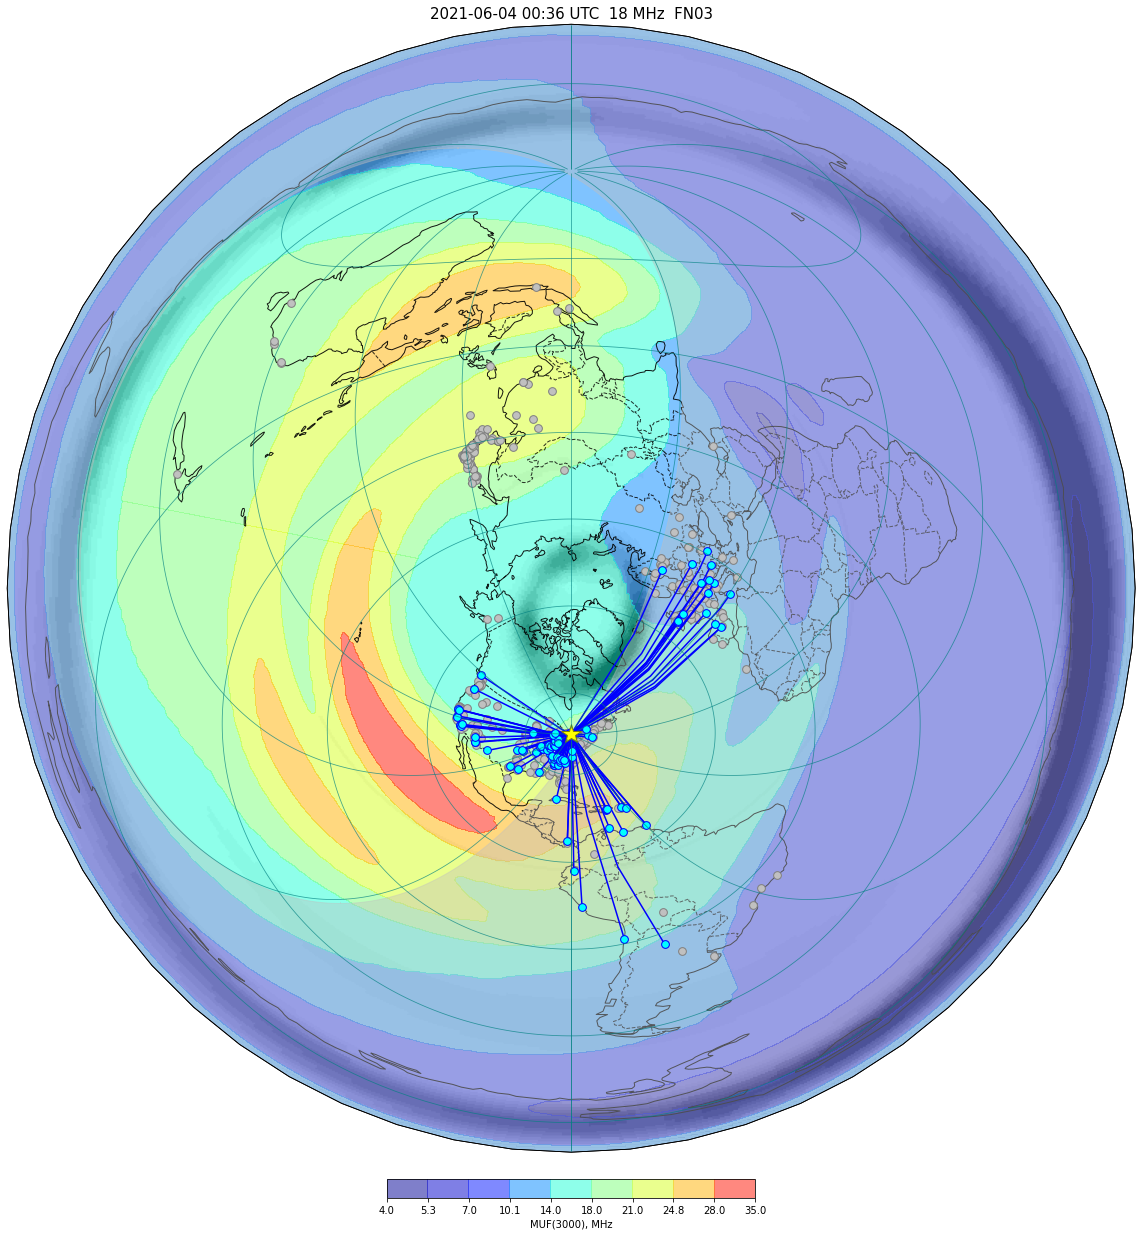

Wall time: 11 s


In [7]:
%%time

projection=Projection.Polar
home_square = 'FN03' #'IM58'
mhz = 18

muf_data = download_muf()
spot_data = download_ft8(home_square=home_square, mhz=mhz)
aurora = download_aurora()

plot_map(muf_data=muf_data, aurora=aurora, grayline=True, mhz=mhz, spot_data=spot_data, projection=projection, home_square=home_square)